___

<a href='http://www.pieriandata.com'><img src='../Pierian_Data_Logo.png'/></a>
___
<center><em>Copyright Pierian Data</em></center>
<center><em>For more information, visit us at <a href='http://www.pieriandata.com'>www.pieriandata.com</a></em></center>
# RNN Example for Time Series

**TASK: IMPORT THE BASIC LIBRARIES YOU THINK YOU WILL USE**

In [1]:
# IMPORTS HERE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data

Info about this data set: https://fred.stlouisfed.org/series/TRFVOLUSM227NFWA

Read in the data set "Miles_Traveled.csv" from the Data folder. Figure out how to set the date to a datetime index columns

In [2]:
df=pd.read_csv('../Data/Miles_Traveled.csv',index_col='DATE',parse_dates=True)
df.index.freq='MS'

In [3]:
df.head()

,TRFVOLUSM227NFWA
DATE,
1970-01-01,80173.0
1970-02-01,77442.0
1970-03-01,90223.0
1970-04-01,89956.0
1970-05-01,97972.0


**Task: Change the column names to Value**

In [4]:
df.columns=['Value']

**TASK: Plot out the time series**

<AxesSubplot:xlabel='DATE'>

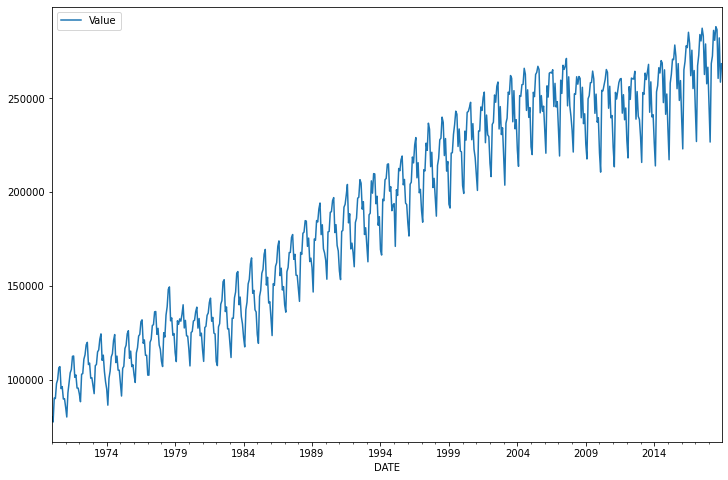

In [5]:
df.plot(figsize=(12,8))

**TASK: Perform a Seasonal Decomposition on the model and plot out the ETS components**

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [8]:
results=seasonal_decompose(df['Value'])
# results.plot();

<AxesSubplot:xlabel='DATE'>

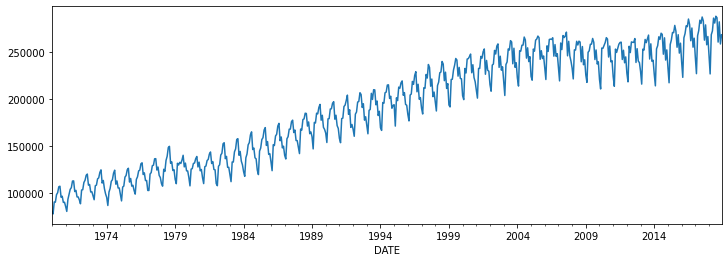

In [10]:
results.observed.plot(figsize=(12,4))

<AxesSubplot:xlabel='DATE'>

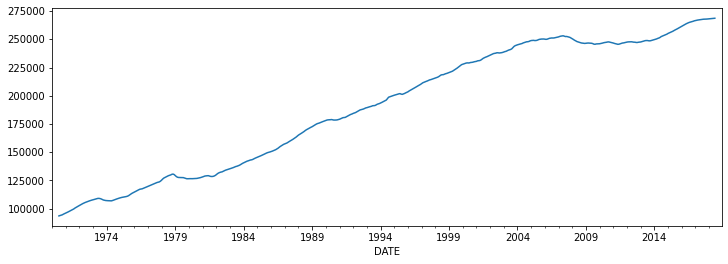

In [11]:
results.trend.plot(figsize=(12,4))

<AxesSubplot:xlabel='DATE'>

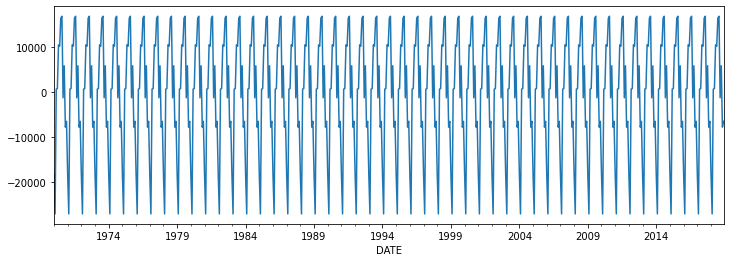

In [12]:
results.seasonal.plot(figsize=(12,4))

<AxesSubplot:xlabel='DATE'>

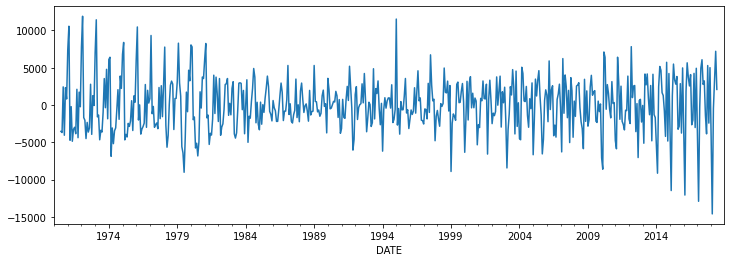

In [13]:
results.resid.plot(figsize=(12,4))

## Train Test Split

**TASK: Figure out the length of the data set**

In [14]:
len(df)

588

In [15]:
588-12

576

**TASK: Split the data into a train/test split where the test set is the last 12 months of data.**

In [17]:
train= df.iloc[:576]
test=df.iloc[576:]
print(test.shape, train.shape)

(12, 1) (576, 1)


## Scale Data

**TASK: Use a MinMaxScaler to scale the train and test sets into scaled versions.**

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(train)
scaled_train=scaler.transform(train)
scaled_test=scaler.transform(test)

# Time Series Generator

**TASK: Create a TimeSeriesGenerator object based off the scaled_train data. The n_input is up to you, but at a minimum it should be at least 12.**

In [19]:
from keras.preprocessing.sequence import TimeseriesGenerator
n_input=12
n_features=1

generator=TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)

### Create the Model

**TASK: Create a Keras Sequential Model with as many LSTAM units you want and a final Dense Layer.**

In [20]:
from keras.models import Sequential
from keras.layers import Dense,LSTM

In [21]:
model=Sequential()
model.add(LSTM(150,activation='relu',input_shape=(n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150)               91200     
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


**TASK: Fit the model to the generator (it should be a lot of epochs, but do as many as you have the patience for! :)**

In [23]:
model.fit_generator(generator,epochs=20)

C:\Users\ASUS\AppData\Local\Temp/ipykernel_22280/3989200883.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20)


Epoch 1/20
564/564 [==============================] - 4s 5ms/step - loss: 0.0120
Epoch 2/20
564/564 [==============================] - 3s 5ms/step - loss: 0.0055
Epoch 3/20
564/564 [==============================] - 3s 4ms/step - loss: 0.0051
Epoch 4/20
564/564 [==============================] - 2s 4ms/step - loss: 0.0045
Epoch 5/20
564/564 [==============================] - 2s 4ms/step - loss: 0.0036
Epoch 6/20
564/564 [==============================] - 2s 4ms/step - loss: 0.0022
Epoch 7/20
564/564 [==============================] - 2s 4ms/step - loss: 0.0020
Epoch 8/20
564/564 [==============================] - 2s 4ms/step - loss: 0.0013
Epoch 9/20
564/564 [==============================] - 2s 4ms/step - loss: 0.0011
Epoch 10/20
564/564 [==============================] - 2s 4ms/step - loss: 0.0012
Epoch 11/20
564/564 [==============================] - 3s 5ms/step - loss: 0.0010
Epoch 12/20
564/564 [==============================] - 3s 5ms/step - loss: 8.8607e-04
Epoch 13/20
564/564 [

**TASK: Plot the history of the loss that occured during training.**

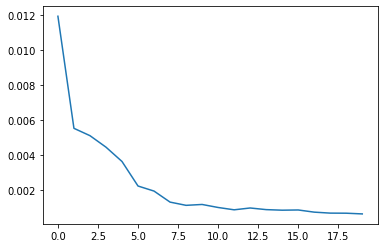

In [24]:
loss_per_epoch=model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

## Evaluate on Test Data

**TASK: Based on your test data and input size, create an appropriate;y sized "first evaluation batch" like we did in the lecture.**

In [26]:
first_eval_batch=scaled_train[-12:]
first_eval_batch

array([[0.79630397],
       [0.71226435],
       [0.90477416],
       [0.93121043],
       [0.98386382],
       [0.96757519],
       [1.        ],
       [0.9801859 ],
       [0.8824684 ],
       [0.95995255],
       [0.85883345],
       [0.90086755]])

**TASK: Generate predictions into the same time stamps as the test set**

In [27]:
test_prediction=[]
first_eval_batch=scaled_train[-n_input:]
current_batch=first_eval_batch.reshape((1,n_input,n_features))

for i in range(len(test)):
    current_pred=model.predict(current_batch)[0]
    test_prediction.append(current_pred)

    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

## Inverse Transformations and Compare

**TASK: Inverse Transform your new forecasted predictions.**

In [28]:
true_prediction=scaler.inverse_transform(test_prediction)
true_prediction

array([[248441.94059122],
       [237765.21477556],
       [268153.4387995 ],
       [275133.27970952],
       [285113.65162718],
       [284041.21482843],
       [289112.71651626],
       [284394.62766212],
       [269851.36677003],
       [279114.06591868],
       [263442.13094777],
       [267931.15453809]])

**TASK: Create a new dataframe that has both the original test values and your predictions for them.**

In [31]:
test['Predictions'] = true_prediction
test

C:\Users\ASUS\AppData\Local\Temp/ipykernel_22280/4219339879.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_prediction


,Value,Predictions
DATE,,
2018-01-01,245695.0,248441.940591
2018-02-01,226660.0,237765.214776
2018-03-01,268480.0,268153.438800
2018-04-01,272475.0,275133.279710
2018-05-01,286164.0,285113.651627
2018-06-01,280877.0,284041.214828
2018-07-01,288145.0,289112.716516
2018-08-01,286608.0,284394.627662
2018-09-01,260595.0,269851.366770


**TASK: Plot out the test set against your own predicted values.**

<AxesSubplot:xlabel='DATE'>

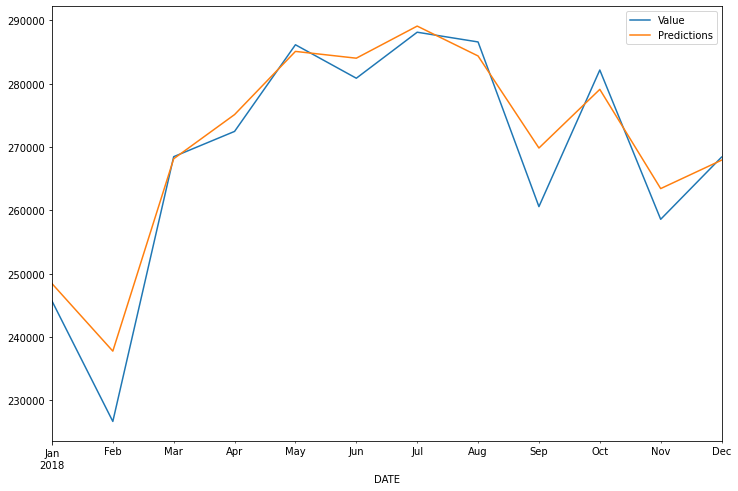

In [32]:
test.plot(figsize=(12,8))

# Saving Models

**TASK: Optional, Save your model!**

In [33]:
model.save('solutions_model.h5')